<a href="https://colab.research.google.com/github/yigalk89/hatespeech-adversarial-attacks/blob/master/different_models_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Models evaluation on hate speech
This notebook has the code that test the following models on the `hatexplain` and `hatecheck` hate speech datasets

#### Prepare dependecies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!git clone https://github.com/alatteaday/mrp_hate-speech-detection.git

Cloning into 'mrp_hate-speech-detection'...
remote: Enumerating objects: 11526, done.
remote: Counting objects: 100% (11526/11526), done.
remote: Compressing objects: 100% (10519/10519), done.
remote: Total 11526 (delta 54), reused 11499 (delta 36), pack-reused 0 (from 0)
Receiving objects: 100% (11526/11526), 6.53 MiB | 4.74 MiB/s, done.
Resolving deltas: 100% (54/54), done.
Updating files: 100% (11484/11484), done.


In [3]:
!pip install emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 11.6 MB/s eta 0:00:00


Data set download and adaptations

In [4]:
!git clone https://github.com/paul-rottger/hatecheck-data.git

Cloning into 'hatecheck-data'...
remote: Enumerating objects: 52, done.
remote: Counting objects: 100% (52/52), done.
remote: Compressing objects: 100% (49/49), done.
remote: Total 52 (delta 27), reused 3 (delta 2), pack-reused 0 (from 0)
Receiving objects: 100% (52/52), 213.17 KiB | 5.20 MiB/s, done.
Resolving deltas: 100% (27/27), done.


### Define custom dataset classes
This classes will be used for evaluation of the models

In [5]:
import pandas as pd
from torch.utils.data import Dataset, DataLoader

class TextDataset(Dataset):
    def __init__(self, csv_file):
        # Load the CSV file into a DataFrame
        self.data = pd.read_csv(csv_file)

        # Extract relevant columns
        self.texts = self.data['test_case'].tolist()
        self.labels = self.data['label_gold'].tolist()
        self.functionalities = self.data['functionality'].tolist()
        self.label_list = ['non-hateful', 'hateful']
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        # Get the text, label, and functionality for the index
        text = self.texts[idx]
        label = self.labels[idx]
        functionality = self.functionalities[idx]
        cls_num = self.label_list.index(label)
        return (text, cls_num, functionality)

In [6]:
import json
import os
import emoji
class HateXplainDatasetForBias(Dataset):
    def __init__(self, dir_hatexplain, mode='train'):
        assert mode in ['train', 'val', 'test'], "mode should be [train/val/test]"

        data_root = dir_hatexplain
        data_dir = os.path.join(data_root, 'hatexplain_two_div.json')
        with open(data_dir, 'r') as f:
            dataset = json.load(f)

        self.label_list = ['non-toxic', 'toxic']
        self.label_count = [0, 0]

        if mode == 'train':
            self.dataset = dataset['train']
            for d in self.dataset:
                if d['final_label'] == self.label_list[0]:
                    self.label_count[0] += 1
                elif d['final_label'] == self.label_list[1]:
                    self.label_count[1] += 1
                else:
                    print("[!] exceptional label ", d['final_label'])
                    return
        elif mode == 'val':
            self.dataset = dataset['val']
        else:  # 'test'
            self.dataset = dataset['test']

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        post_id = self.dataset[idx]['post_id']
        text = ' '.join(self.dataset[idx]['text'])
        text = emoji.demojize(text)
        label = self.dataset[idx]['final_label']
        cls_num = self.label_list.index(label)

        return (text, cls_num, post_id)


In [21]:
import json
import os
import emoji
class HateXplainDatasetForBiasPerturbed(Dataset):
    def __init__(self,  mode='train'):
        assert mode in ['train', 'val', 'test'], "mode should be [train/val/test]"
        json_path = '/content/drive/MyDrive/NLP/test_transformed_data_clean_v3.json' #'/content/drive/MyDrive/perturbed_list_GPT_hate_explain.json' #'/content/drive/MyDrive/test_transformed_manual_clean.json'
        with open(json_path, 'r') as f:
          self.dataset = json.load(f)

        self.label_list = ['non-toxic', 'toxic']
        self.label_count = [0, 0]
        self.post_id_counter = 0


    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        text = self.dataset[idx]['transformed_text']
        text = emoji.demojize(text)
        label = self.dataset[idx]['final_label']
        cls_num = self.label_list.index(label)
        self.post_id_counter +=1
        return (text, cls_num)


### Helper functions for evaulating the models

In [8]:
def create_dataloader(csv_file, batch_size=1):
    dataset = TextDataset(csv_file)
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False)
    return dataloader

In [31]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix,ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from collections import defaultdict
import time
from transformers import pipeline

def classify_text(text, pipe_test):
    try:
        result = pipe_test(text)  # Use the pipeline to classify the text
        label = result[0]['label']  # Extract the label
        return label
    except Exception as e:
        return f"Error: {e}"  # Handle errors gracefully

def get_pred_cls(logits):
    probs = F.softmax(logits, dim=1)
    #labels = labels.detach().cpu().numpy()
    probs = probs.detach().cpu().numpy()
    max_probs = np.max(probs, axis=1).tolist()
    probs = probs.tolist()
    pred_clses = []
    for m, p in zip(max_probs, probs):
        pred_clses.append(p.index(m))

    return probs, pred_clses

def get_device():
  if torch.cuda.is_available():
      print("device = cuda")
      return torch.device('cuda')
  else:
      print("device = cpu")
      return torch.device('cpu')

def evaluate(model, dataloader, tokenizer, device):
    losses = []
    consumed_time = 0
    total_pred_clses, total_gt_clses, total_probs = [], [], []

    bias_dict_list, explain_dict_list = [], []
    # label_dict = {1:'hateful', 0:'non-hateful'}

    preds_lbls_per_func = defaultdict(lambda: {'predictions': [], 'labels': []})

    model.eval()
    with torch.no_grad():
        for i, batch in enumerate(tqdm(dataloader, desc="EVAL | # {}".format(0), mininterval=0.01)):
            texts, labels = batch[0], batch[1]



            in_tensor = tokenizer(texts, return_tensors='pt', padding=True)
            in_tensor = in_tensor.to(device)
            gts_tensor = labels.to(device)

            start_time = time.time()
            out_tensor = model(**in_tensor, labels=gts_tensor)
            consumed_time += time.time() - start_time

            loss = out_tensor.loss
            logits = out_tensor.logits
            if i < 10:
              print("Texts:", texts)
              print("Labels:", labels)
              print("Logits:", logits)

            losses.append(loss.item())

            probs, pred_clses = get_pred_cls(logits)
            labels_list = labels.tolist()

            total_gt_clses += labels_list
            total_pred_clses += pred_clses
            total_probs += probs




    time_avg = consumed_time / len(dataloader)
    loss_avg = [sum(losses) / len(dataloader)]
    acc = [accuracy_score(total_gt_clses, total_pred_clses)]
    f1 = f1_score(total_gt_clses, total_pred_clses, average='macro')
    cm = confusion_matrix(total_gt_clses, total_pred_clses)



    return losses, loss_avg, acc, f1, time_avg, cm

In [10]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
df_ch = pd.DataFrame()
def statistics_for_classification(model_name, classification_column, hate_label, dataset=None):
    dataset = df_hc if dataset is None else dataset
    dataset['label_gold_binary'] = dataset['label_gold'].apply(lambda x: 1 if x == 'hateful' else 0)
    dataset['classification_binary'] = dataset[classification_column].apply(lambda x: 1 if x==hate_label else 0)
    true_labels = dataset['label_gold_binary']
    predicted_labels = dataset['classification_binary']
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['non-hateful', 'hateful'])
    disp.plot()
    print(model_name)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

In [11]:
def statistics_for_classification_v2(df_hc, model_name, classification_column, hate_label):
    # Check Unique Values
    print("Unique values in 'transformed_text':", df_hc['transformed_text'].unique())
    print("Unique values in 'classification_pipe_rationale2':", df_hc[classification_column].unique())

    df_hc['label_gold_binary'] = df_hc['final_label'].apply(lambda x: 1 if x == 'toxic' else 0)  # Changed column to 'final_label'
    df_hc['classification_binary'] = df_hc[classification_column].apply(lambda x: 1 if x==hate_label else 0)

    # Check Unique Values after Transformation
    print("Unique values in 'label_gold_binary':", df_hc['label_gold_binary'].unique())
    print("Unique values in 'classification_binary':", df_hc['classification_binary'].unique())

    true_labels = df_hc['label_gold_binary']
    predicted_labels = df_hc['classification_binary']
    accuracy = accuracy_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)
    conf_matrix = confusion_matrix(true_labels, predicted_labels)

    # Adjust display_labels if necessary
    unique_labels = sorted(list(set(true_labels.unique().tolist() + predicted_labels.unique().tolist())))
    display_labels = ['non-hateful' if label == 0 else 'hateful' for label in unique_labels]
    disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=display_labels)

    disp.plot()
    print(model_name)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1 Score: {f1:.4f}")

### Load datasets

In [12]:
# Load hate_explain dataset
hate_explain_dir = "/content/mrp_hate-speech-detection/dataset"

hate_explain_dataset = HateXplainDatasetForBias(hate_explain_dir, mode='test')
hate_explain_dataloader = DataLoader(hate_explain_dataset, shuffle=False)#, batch_size=batch_size

In [23]:
# Load the perturbed hate explain dataset
hate_explain_dataset_perturbed = HateXplainDatasetForBiasPerturbed(mode='test')
hate_explain_dataloader_perturbed = DataLoader(hate_explain_dataset_perturbed,  shuffle=False) #batch_size=batch_size,

In [16]:
# Load clean transformed version of hatecheck
def load_clean_transformed_hatecheck():
  json_path = '/content/drive/MyDrive/NLP/test_transformed_manual_clean.json'
  df = pd.read_json(json_path)
  return df

clean_transformed_hatecheck_df = load_clean_transformed_hatecheck()

In [17]:
# Load hatecheck standart test suite case
df_hc = pd.read_csv('/content/hatecheck-data/test_suite_cases.csv')

## Models evaluation


In [18]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline
from transformers import pipeline

### **1. Rationale2**


In [ ]:
# Load Rationale2 model

pipe_rationale2 = pipeline("text-classification", model="Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two")
tokenizer_rationale2 = AutoTokenizer.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two")
model_rationale2 = AutoModelForSequenceClassification.from_pretrained("Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two")
device = get_device()
model_rationale2.to(device)
model_rationale2.config.output_attentions=True

config.json:   0%|          | 0.00/790 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of the model checkpoint at Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two were not used when initializing BertForSequenceClassification: ['bert_pooler.dense.bias', 'bert_pooler.dense.weight', 'token_classifier.bias', 'token_classifier.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight

tokenizer_config.json:   0%|          | 0.00/299 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
Some weights of the model checkpoint at Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two were not used when initializing BertForSequenceClassification: ['bert_pooler.dense.bias', 'bert_pooler.dense.weight', 'token_classifier.bias', 'token_classifier.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at Hate-speech-CNERG/bert-base-uncased-hatexplain-rationale-two and are newly initialized: ['bert.pooler.dense.bias', 'be

device = cpu


In [ ]:
# Use hatecheck test suite case for initial evaluation
df_hc['classification_pipe_rationale2'] = df_hc['test_case'].apply(lambda x: classify_text(x, pipe_rationale2))
df_hc['classification_pipe_rationale2'].value_counts()

,count
classification_pipe_rationale2,
NORMAL,3605
ABUSIVE,123


rationale-two
Accuracy: 0.3342
F1 Score: 0.0759


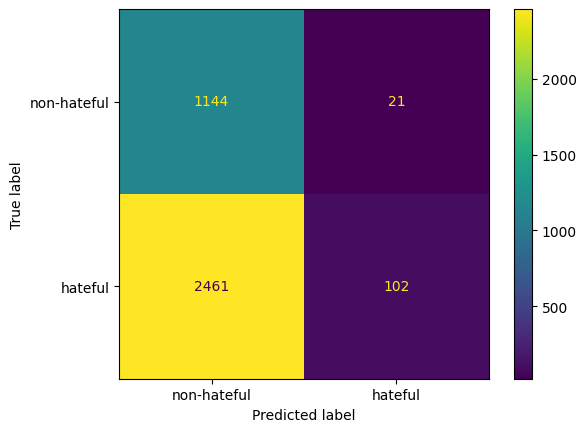

In [ ]:
statistics_for_classification('rationale-two', 'classification_pipe_rationale2', 'ABUSIVE')


In [ ]:
# Evaluate Rationale2 on hate explaine test set
losses, loss_avg, acc, f1, time_avg, cm = evaluate(model_rationale2, hate_explain_dataloader, tokenizer_rationale2, device)


EVAL | # 0:   0%|          | 1/1924 [00:00<16:08,  1.99it/s]

Texts: ('<user> men can not be raped can not be abused that why they call it violence against women and children because men are always the perpetrators women come first even before children',)
Labels: tensor([0])
Logits: tensor([[-0.1992,  0.0008]])


EVAL | # 0:   0%|          | 2/1924 [00:00<13:23,  2.39it/s]

Texts: ('<user> you are missing an essential premise whether any of those immigrants committed any crimes dumbass',)
Labels: tensor([0])
Logits: tensor([[-0.1023, -0.1343]])


EVAL | # 0:   0%|          | 3/1924 [00:01<13:02,  2.45it/s]

Texts: ('<user> <user> why are you repeating yourself are you a little retarded',)
Labels: tensor([1])
Logits: tensor([[-0.1824,  0.0226]])


EVAL | # 0:   0%|          | 4/1924 [00:01<12:55,  2.48it/s]

Texts: ('<user> <user> well she ’ muslim so of course she hates the jews jew hatred is one of the defining feature of islam',)
Labels: tensor([1])
Logits: tensor([[-0.1687, -0.0771]])


EVAL | # 0:   0%|          | 5/1924 [00:02<17:54,  1.79it/s]

Texts: ('<user> lol not me i don ’ t deal with bms not outside children ’ ss i leave that ghetto mess for everybody else :face_with_tears_of_joy: :face_with_tears_of_joy: :face_with_tears_of_joy:',)
Labels: tensor([1])
Logits: tensor([[-0.1079, -0.0024]])


EVAL | # 0:   0%|          | 6/1924 [00:02<14:14,  2.25it/s]

Texts: ('an these nigger biches look like godzilla nasty',)
Labels: tensor([1])
Logits: tensor([[-0.1224,  0.1284]])


EVAL | # 0:   0%|          | 7/1924 [00:02<11:57,  2.67it/s]

Texts: ('yeah humnh what how do i use this app i ’ m alittle retarded :ogre:',)
Labels: tensor([1])
Logits: tensor([[-0.1057, -0.0115]])


EVAL | # 0:   0%|          | 8/1924 [00:03<12:38,  2.53it/s]

Texts: ('black people are oppressed by their own culture and community blacks need to wake and realize the democrats party is the racist party that uses them for votes the kk democrats have broken up the black family and run the community onto the ghetto plantation to control it youvebeenpunkd',)
Labels: tensor([1])
Logits: tensor([[-0.1043,  0.1172]])


EVAL | # 0:   1%|          | 10/1924 [00:03<09:15,  3.44it/s]

Texts: ('education or marxist indoctrination since it is well established blacks are incapable of learning anything past the age of ten unless they are half white should not blacks go to a trade school upon age <number> say learning how to pick cotton fruits and vegetables',)
Labels: tensor([1])
Logits: tensor([[ 0.0030, -0.0961]])
Texts: ('fell outta love and found a boss bitch',)
Labels: tensor([0])
Logits: tensor([[ 0.0185, -0.0281]])


EVAL | # 0: 100%|██████████| 1924/1924 [06:20<00:00,  5.06it/s]


Loss_avg: [0.6607747238106143] / min: 0.5053178071975708 / max: 0.8957202434539795 | Consumed_time: 0.19329831567970482

** Performance-based Scores **
Acc: 0.6741164241164241 | F1: 0.5998228582517702  



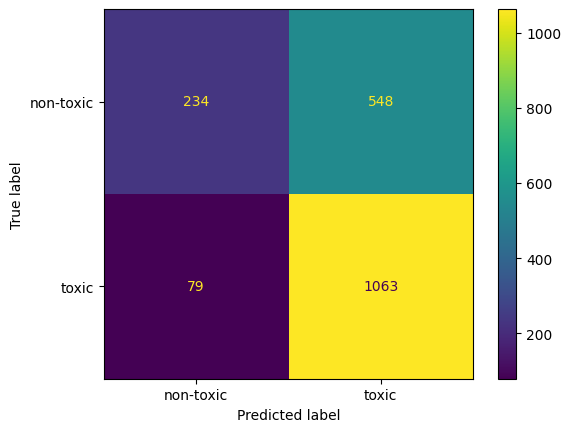

In [ ]:
print("Loss_avg: {} / min: {} / max: {} | Consumed_time: {}\n".format(loss_avg, min(losses), max(losses), time_avg))
print("** Performance-based Scores **")
print("Acc: {} | F1: {}  \n".format(acc[0], f1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic'])

disp.plot()
plt.show()

EVAL | # 0:   0%|          | 0/1924 [00:00<?, ?it/s]BertSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
EVAL | # 0:   0%|          | 1/1924 [00:00<20:23,  1.57it/s]

Texts: ('<user> men can not be raped can not be abused that why they call it violence against women and children because men are always the perpetrators women come first even before children',)
Labels: tensor([0])
Logits: tensor([[-0.1532,  0.0407]])


EVAL | # 0:   0%|          | 2/1924 [00:00<12:37,  2.54it/s]

Texts: ('<user> you are missing an essential premise whether any of those immigrants committed any crimes dumbass',)
Labels: tensor([0])
Logits: tensor([[0.0540, 0.1824]])


EVAL | # 0:   0%|          | 3/1924 [00:01<12:25,  2.58it/s]

Texts: ('<user> <user> why are you repeating yourself are you a little retarded',)
Labels: tensor([1])
Logits: tensor([[0.0254, 0.1830]])


EVAL | # 0:   0%|          | 4/1924 [00:01<11:53,  2.69it/s]

Texts: ('<user> <user> well she ’ muslim so of course she hates the jews jew hatred is one of the defining feature of islam',)
Labels: tensor([1])
Logits: tensor([[0.1052, 0.1108]])


EVAL | # 0:   0%|          | 5/1924 [00:02<17:33,  1.82it/s]

Texts: ('<user> lol not me i don ’ t deal with bms not outside children ’ ss i leave that ghetto mess for everybody else :face_with_tears_of_joy: :face_with_tears_of_joy: :face_with_tears_of_joy:',)
Labels: tensor([1])
Logits: tensor([[0.0254, 0.1210]])


EVAL | # 0:   0%|          | 6/1924 [00:02<14:58,  2.13it/s]

Texts: ('an these nigger biches look like godzilla nasty',)
Labels: tensor([1])
Logits: tensor([[0.0340, 0.1051]])


EVAL | # 0:   0%|          | 7/1924 [00:03<14:22,  2.22it/s]

Texts: ('yeah humnh what how do i use this app i ’ m alittle retarded :ogre:',)
Labels: tensor([1])
Logits: tensor([[-0.0255,  0.1880]])


EVAL | # 0:   0%|          | 8/1924 [00:03<14:27,  2.21it/s]

Texts: ('black people are oppressed by their own culture and community blacks need to wake and realize the democrats party is the racist party that uses them for votes the kk democrats have broken up the black family and run the community onto the ghetto plantation to control it youvebeenpunkd',)
Labels: tensor([1])
Logits: tensor([[0.1427, 0.1336]])


EVAL | # 0:   1%|          | 10/1924 [00:04<11:00,  2.90it/s]

Texts: ('education or marxist indoctrination since it is well established blacks are incapable of learning anything past the age of ten unless they are half white should not blacks go to a trade school upon age <number> say learning how to pick cotton fruits and vegetables',)
Labels: tensor([1])
Logits: tensor([[0.1808, 0.1844]])
Texts: ('fell outta love and found a boss bitch',)
Labels: tensor([0])
Logits: tensor([[-0.0313,  0.1354]])


EVAL | # 0: 100%|██████████| 1924/1924 [07:04<00:00,  4.53it/s]


Loss_avg: [0.6887582161012658] / min: 0.5175471901893616 / max: 0.8835873603820801 | Consumed_time: 0.21587268912123048

** Performance-based Scores **
Acc: 0.5446985446985447 | F1: 0.4342840341076154  



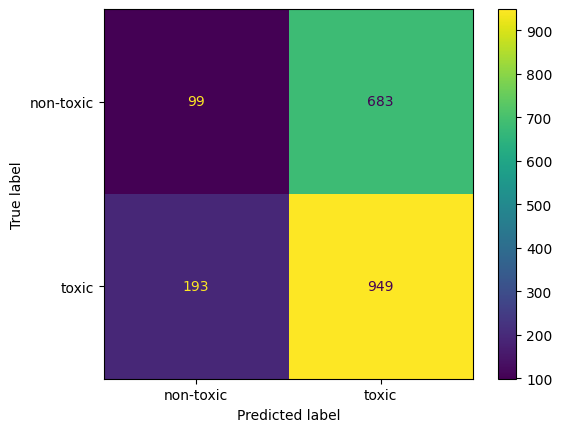

In [ ]:
# Evaluate Rationale2 model on perturbed hate_explain
losses, loss_avg, acc, f1, time_avg, cm, _ = evaluate(model_rationale2, hate_explain_dataloader_perturbed, tokenizer_rationale2, device)

print("Loss_avg: {} / min: {} / max: {} | Consumed_time: {}\n".format(loss_avg, min(losses), max(losses), time_avg))
print("** Performance-based Scores **")
print("Acc: {} | F1: {}  \n".format(acc[0], f1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic'])

disp.plot()
plt.show()

Unique values in 'transformed_text': ['Those two individuals were the first bigoted people in the presidential residence.'
 '"Is there any use in responding to this intellectually challenged individual, I suppose not, continue living in your happiness."'
 "If you cover the costs for the military carrying out the bidding of the Jews, I will not stand for it. The agriculture department functions at the president's convenience, and he has the authority to instruct the agriculture department to apprehend them."
 ...
 'Jewish people are the sole adversaries in the entirety of global history who revert to invoking anti-Semitism as a means to resist my actions, oh woe is me.'
 'Gratitude to Jewish people for initiating it.'
 'To be frank, the only female I would never consider for a relationship is a dark-skinned woman. Hispanic women are acceptable, and so are Asians, though my preference for them has waned. However, Caucasian women can be mentally unstable. Women of Indian and Arab descent 

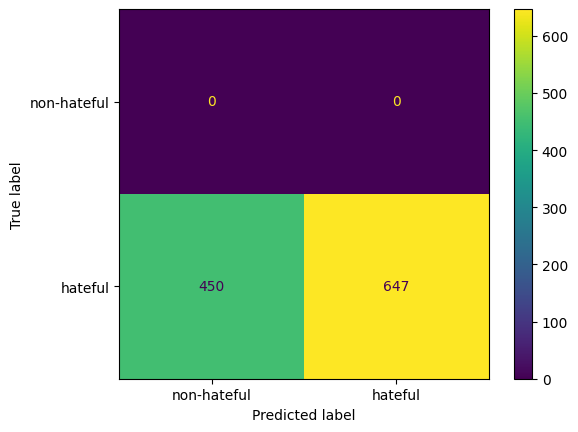

In [ ]:
# Re-evaluate the Rationale2 model behavior on a cleaned version
# of the perturbed hatecheck dataset
clean_transformed_hatecheck_df['classification_pipe_rationale2'] = clean_transformed_hatecheck_df['transformed_text'].apply(lambda x: classify_text(x, pipe_rationale2))
statistics_for_classification_v2(clean_transformed_hatecheck_df, 'rationale-two', 'classification_pipe_rationale2', 'ABUSIVE')


### **2. RoBERTa Hate Speech**


In [19]:
# Load RoBERTa Hate Speech model
tokenizer_roberta_hate = AutoTokenizer.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
model_roberta_hate = AutoModelForSequenceClassification.from_pretrained("facebook/roberta-hate-speech-dynabench-r4-target")
device = get_device()
model_roberta_hate.to(device)
model_roberta_hate.config.output_attentions=True
pipe_roberta_hate = pipeline("text-classification", model="facebook/roberta-hate-speech-dynabench-r4-target")



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/1.11k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/816 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

device = cuda


Device set to use cuda:0


Device set to use cpu


roberta-hate
Accuracy: 0.9560
F1 Score: 0.9682


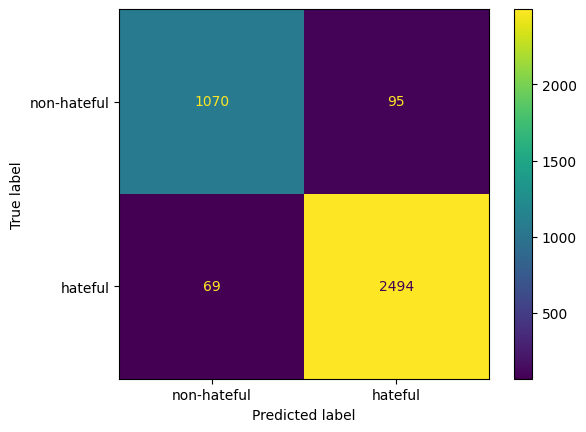

In [ ]:
# Use hatecheck test suite case for initial evaluation
df_hc['classification_roberta_hate'] = df_hc['test_case'].apply(lambda x: classify_text(x, pipe_roberta_hate))
statistics_for_classification('roberta-hate', 'classification_roberta_hate', 'hate')


In [ ]:
# Evaluate RoBERTa Hate Speech on hate explaine test set
losses, loss_avg, acc, f1, time_avg, cm = evaluate(model_roberta_hate, hate_explain_dataloader, tokenizer_roberta_hate, device)


EVAL | # 0:   0%|          | 1/1924 [00:00<13:40,  2.34it/s]

Texts: ('<user> men can not be raped can not be abused that why they call it violence against women and children because men are always the perpetrators women come first even before children',)
Labels: tensor([0])
Logits: tensor([[ 0.7073, -0.6594]])


EVAL | # 0:   0%|          | 2/1924 [00:00<09:41,  3.30it/s]

Texts: ('<user> you are missing an essential premise whether any of those immigrants committed any crimes dumbass',)
Labels: tensor([0])
Logits: tensor([[-0.8224,  0.4746]])
Texts: ('<user> <user> why are you repeating yourself are you a little retarded',)
Labels: tensor([1])
Logits: tensor([[-1.4465,  1.1845]])


EVAL | # 0:   0%|          | 4/1924 [00:01<09:19,  3.43it/s]

Texts: ('<user> <user> well she ’ muslim so of course she hates the jews jew hatred is one of the defining feature of islam',)
Labels: tensor([1])
Logits: tensor([[-1.2222,  0.8895]])


EVAL | # 0:   0%|          | 6/1924 [00:01<09:51,  3.24it/s]

Texts: ('<user> lol not me i don ’ t deal with bms not outside children ’ ss i leave that ghetto mess for everybody else :face_with_tears_of_joy: :face_with_tears_of_joy: :face_with_tears_of_joy:',)
Labels: tensor([1])
Logits: tensor([[-0.6041,  0.3148]])
Texts: ('an these nigger biches look like godzilla nasty',)
Labels: tensor([1])
Logits: tensor([[-4.2413,  3.7721]])


EVAL | # 0:   0%|          | 7/1924 [00:02<09:00,  3.55it/s]

Texts: ('yeah humnh what how do i use this app i ’ m alittle retarded :ogre:',)
Labels: tensor([1])
Logits: tensor([[-1.0961,  0.7521]])


EVAL | # 0:   0%|          | 8/1924 [00:02<10:48,  2.96it/s]

Texts: ('black people are oppressed by their own culture and community blacks need to wake and realize the democrats party is the racist party that uses them for votes the kk democrats have broken up the black family and run the community onto the ghetto plantation to control it youvebeenpunkd',)
Labels: tensor([1])
Logits: tensor([[-0.9054,  0.5590]])


EVAL | # 0:   0%|          | 9/1924 [00:03<14:45,  2.16it/s]

Texts: ('education or marxist indoctrination since it is well established blacks are incapable of learning anything past the age of ten unless they are half white should not blacks go to a trade school upon age <number> say learning how to pick cotton fruits and vegetables',)
Labels: tensor([1])
Logits: tensor([[-2.6830,  2.4011]])


EVAL | # 0:   1%|          | 10/1924 [00:03<15:03,  2.12it/s]

Texts: ('fell outta love and found a boss bitch',)
Labels: tensor([0])
Logits: tensor([[-3.6164,  3.2102]])


EVAL | # 0: 100%|██████████| 1924/1924 [06:08<00:00,  5.21it/s]


Loss_avg: [0.9906081551174464] / min: 0.00013290952483657748 / max: 8.88174057006836 | Consumed_time: 0.18759795248880207

** Performance-based Scores **
Acc: 0.7318087318087318 | F1: 0.7064002697091755  



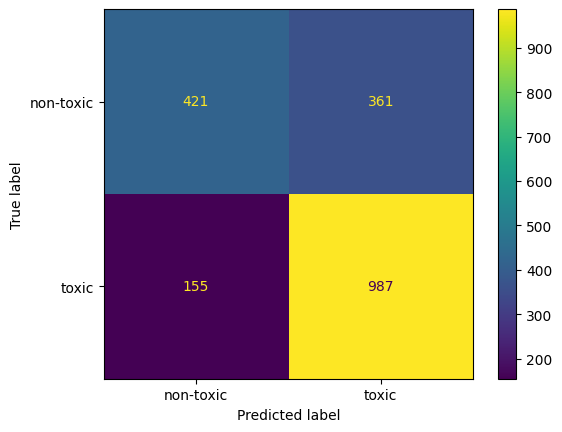

In [ ]:
print("Loss_avg: {} / min: {} / max: {} | Consumed_time: {}\n".format(loss_avg, min(losses), max(losses), time_avg))
print("** Performance-based Scores **")
print("Acc: {} | F1: {}  \n".format(acc[0], f1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic'])

disp.plot()
plt.show()

In [24]:
# Evaluate RoBERTa Hate Speech model on perturbed hate_explain
losses, loss_avg, acc, f1, time_avg, cm = evaluate(model_roberta_hate, hate_explain_dataloader_perturbed, tokenizer_roberta_hate, device)

EVAL | # 0:   0%|          | 0/1067 [00:00<?, ?it/s]RobertaSdpaSelfAttention is used but `torch.nn.functional.scaled_dot_product_attention` does not support non-absolute `position_embedding_type` or `output_attentions=True` or `head_mask`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.


Texts: ('"Is there any use in responding to this intellectually challenged individual, I suppose not, continue living in your happiness."',)
Labels: tensor([1])
Logits: 

EVAL | # 0:   1%|          | 8/1067 [00:01<00:59, 17.79it/s]

tensor([[-1.7202,  1.4336]], device='cuda:0')
Texts: ("If you cover the costs for the military carrying out the bidding of the Jews, I will not stand for it. The agriculture department functions at the president's convenience, and he has the authority to instruct the agriculture department to apprehend them.",)
Labels: tensor([1])
Logits: tensor([[-2.7580,  2.5033]], device='cuda:0')
Texts: ('Individuals leaning left are entirely indoctrinated and intellectually challenged; they need to hear the very same words echoed back at them, which disrupts their programming. Always remember that all left-leaning individuals are merely a type of software program; refrain from using logic and instead appeal to their emotions.',)
Labels: tensor([1])
Logits: tensor([[ 4.2165, -3.7116]], device='cuda:0')
Texts: ('Nazi individuals are first-rate jerks, a mere joke compared to solid republican\\_{number}. The easily-frightened antifa and Hezbollah members are mere grains of sand in comparison. A small 

EVAL | # 0:   2%|▏         | 17/1067 [00:01<00:25, 40.77it/s]

Texts: ('Are you referring to individuals from Arab countries?',)
Labels: tensor([1])
Logits: tensor([[ 4.4934, -3.9481]], device='cuda:0')
Texts: ('I will strike the excrement out of the Caucasian female referred to as a bitch. Do not claim that you desire my African-American male genitalia.',)
Labels: tensor([1])
Logits: tensor([[ 3.2079, -2.8220]], device='cuda:0')


EVAL | # 0: 100%|██████████| 1067/1067 [00:24<00:00, 44.45it/s]


Evaluation for model: RoBERTa Hate Speech
Loss_avg: [2.4625903559710265] / min: 0.00020132421923335642 / max: 8.903438568115234 | Consumed_time: 0.01761941699749304

** Performance-based Scores **
Acc: 0.5154639175257731 | F1: 0.3401360544217687  



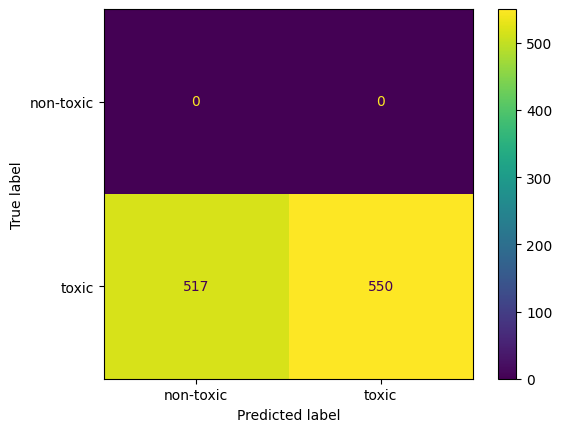

In [25]:
print("Evaluation for model: RoBERTa Hate Speech")
print("Loss_avg: {} / min: {} / max: {} | Consumed_time: {}\n".format(loss_avg, min(losses), max(losses), time_avg))
print("** Performance-based Scores **")
print("Acc: {} | F1: {}  \n".format(acc[0], f1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic'])

disp.plot()
plt.show()

### **3. Bert HateExplain**



In [29]:
# Load Bert HateExplain model
tokenizer_bert_hatexplain = AutoTokenizer.from_pretrained('tum-nlp/bert-hateXplain')
model_bert_hatexplain = AutoModelForSequenceClassification.from_pretrained('tum-nlp/bert-hateXplain')
hate_bert_hatexplain = pipeline("text-classification", model=model_bert_hatexplain, tokenizer=tokenizer_bert_hatexplain)
device = get_device()
model_bert_hatexplain.to(device)
model_bert_hatexplain.config.output_attentions=True

Device set to use cuda:0


device = cuda


You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


model.safetensors:   0%|          | 0.00/44.7M [00:00<?, ?B/s]

bert_hatexplain
Accuracy: 0.4724
F1 Score: 0.4806


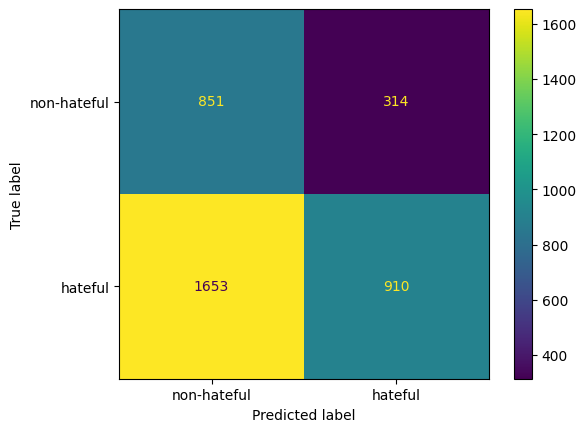

In [27]:
# Use hatecheck test suite case for initial evaluation
df_hc['classification_bert_hatexplain'] = df_hc['test_case'].apply(lambda x: classify_text(x, hate_bert_hatexplain))
statistics_for_classification('bert_hatexplain', 'classification_bert_hatexplain', 'toxic')


In [ ]:
# Evaluate Bert HateExplain on hate explain test set
losses, loss_avg, acc, f1, time_avg, cm = evaluate(model_bert_hatexplain, hate_explain_dataloader, tokenizer_bert_hatexplain, device)


Evaluation for model: Bert HateExplain, dataset: hate explain
Loss_avg: [0.4658276346074553] / min: 0.02565952017903328 / max: 3.6774532794952393 | Consumed_time: 0.004844294144557073

** Performance-based Scores **
Acc: 0.7692307692307693 | F1: 0.7573343180978893  



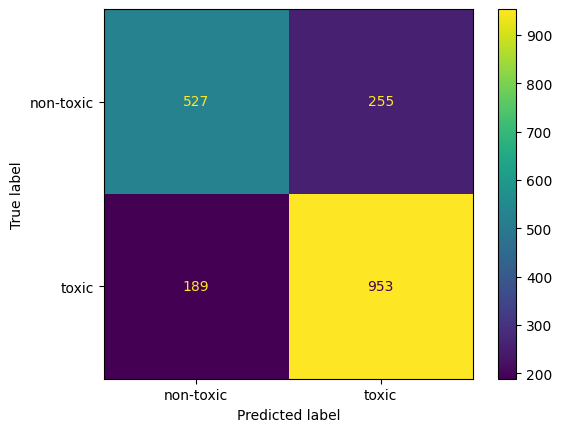

In [33]:
print("Evaluation for model: Bert HateExplain, dataset: hate explain")
print("Loss_avg: {} / min: {} / max: {} | Consumed_time: {}\n".format(loss_avg, min(losses), max(losses), time_avg))
print("** Performance-based Scores **")
print("Acc: {} | F1: {}  \n".format(acc[0], f1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic'])

disp.plot()
plt.show()

In [34]:
# Evaluate Bert HateExplain on perturbed hate explaine test set
losses, loss_avg, acc, f1, time_avg, cm = evaluate(model_bert_hatexplain, hate_explain_dataloader_perturbed, tokenizer_bert_hatexplain, device)

EVAL | # 0:   1%|          | 9/1067 [00:00<00:27, 38.85it/s]

Texts: ('"Is there any use in responding to this intellectually challenged individual, I suppose not, continue living in your happiness."',)
Labels: tensor([1])
Logits: tensor([[ 0.8905, -0.3210]], device='cuda:0')
Texts: ("If you cover the costs for the military carrying out the bidding of the Jews, I will not stand for it. The agriculture department functions at the president's convenience, and he has the authority to instruct the agriculture department to apprehend them.",)
Labels: tensor([1])
Logits: tensor([[-0.0452,  0.3557]], device='cuda:0')
Texts: ('Individuals leaning left are entirely indoctrinated and intellectually challenged; they need to hear the very same words echoed back at them, which disrupts their programming. Always remember that all left-leaning individuals are merely a type of software program; refrain from using logic and instead appeal to their emotions.',)
Labels: tensor([1])
Logits: tensor([[ 1.2426, -0.8375]], device='cuda:0')
Texts: ('Nazi individuals are 

EVAL | # 0:   2%|▏         | 22/1067 [00:00<00:16, 63.88it/s]

 ('I will strike the excrement out of the Caucasian female referred to as a bitch. Do not claim that you desire my African-American male genitalia.',)
Labels: tensor([1])
Logits: tensor([[-0.3491,  0.4687]], device='cuda:0')


EVAL | # 0: 100%|██████████| 1067/1067 [00:12<00:00, 83.54it/s]


Evaluation for model: Bert HateExplain, dataset: perturbed hate explain
Loss_avg: [0.9971986506553235] / min: 0.02949199266731739 / max: 2.558295965194702 | Consumed_time: 0.007703534888684917

** Performance-based Scores **
Acc: 0.3477038425492034 | F1: 0.2579972183588317  



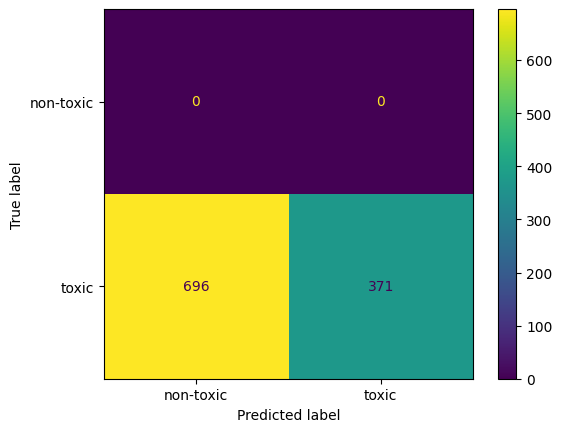

In [35]:
print("Evaluation for model: Bert HateExplain, dataset: perturbed hate explain")
print("Loss_avg: {} / min: {} / max: {} | Consumed_time: {}\n".format(loss_avg, min(losses), max(losses), time_avg))
print("** Performance-based Scores **")
print("Acc: {} | F1: {}  \n".format(acc[0], f1))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['non-toxic', 'toxic'])

disp.plot()
plt.show()